In [1]:
import polars as pl
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
categories = (["electronics", "books", "clothing"] * 334)[:1000]
df = pl.DataFrame({
    "user_id": range(1, 1001),
    "order_value": [20 + i * 0.1 for i in range(1000)],
    "category": categories,
})

print(f"Dataset Shape: {df.shape}")
print(df.head())    

Dataset Shape: (1000, 3)
shape: (5, 3)
┌─────────┬─────────────┬─────────────┐
│ user_id ┆ order_value ┆ category    │
│ ---     ┆ ---         ┆ ---         │
│ i64     ┆ f64         ┆ str         │
╞═════════╪═════════════╪═════════════╡
│ 1       ┆ 20.0        ┆ electronics │
│ 2       ┆ 20.1        ┆ books       │
│ 3       ┆ 20.2        ┆ clothing    │
│ 4       ┆ 20.3        ┆ electronics │
│ 5       ┆ 20.4        ┆ books       │
└─────────┴─────────────┴─────────────┘


In [2]:
print("Data Info:")
print(df.describe())
print("\n Nullvalues:")
print(df.null_count())
summary = df.group_by("category").agg([
    pl.col("order_value").mean().alias("avg_order_value"),
    pl.col("order_value").sum().alias("total_revenue"),
    pl.count().alias("order_count") 
])

print("\n Summary by Category:")
print(summary)

Data Info:
shape: (9, 4)
┌────────────┬────────────┬─────────────┬─────────────┐
│ statistic  ┆ user_id    ┆ order_value ┆ category    │
│ ---        ┆ ---        ┆ ---         ┆ ---         │
│ str        ┆ f64        ┆ f64         ┆ str         │
╞════════════╪════════════╪═════════════╪═════════════╡
│ count      ┆ 1000.0     ┆ 1000.0      ┆ 1000        │
│ null_count ┆ 0.0        ┆ 0.0         ┆ 0           │
│ mean       ┆ 500.5      ┆ 69.95       ┆ null        │
│ std        ┆ 288.819436 ┆ 28.881944   ┆ null        │
│ min        ┆ 1.0        ┆ 20.0        ┆ books       │
│ 25%        ┆ 251.0      ┆ 45.0        ┆ null        │
│ 50%        ┆ 501.0      ┆ 70.0        ┆ null        │
│ 75%        ┆ 750.0      ┆ 94.9        ┆ null        │
│ max        ┆ 1000.0     ┆ 119.9       ┆ electronics │
└────────────┴────────────┴─────────────┴─────────────┘

 Nullvalues:
shape: (1, 3)
┌─────────┬─────────────┬──────────┐
│ user_id ┆ order_value ┆ category │
│ ---     ┆ ---         ┆ ---    

C:\Users\heirm\AppData\Local\Temp\ipykernel_17304\3448722023.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("order_count")


In [3]:
processed_df = df.with_columns([
    (pl.col("order_value") * 1.1).alias("order_with_tax"),
    pl.when(pl.col("order_value") > 50)
        .then(pl.lit("high_value"))
        .otherwise(pl.lit("low_value"))
        .alias("value_segment")
])

print("\n Processed Data Sample:")
print(processed_df.head())  


 Processed Data Sample:
shape: (5, 5)
┌─────────┬─────────────┬─────────────┬────────────────┬───────────────┐
│ user_id ┆ order_value ┆ category    ┆ order_with_tax ┆ value_segment │
│ ---     ┆ ---         ┆ ---         ┆ ---            ┆ ---           │
│ i64     ┆ f64         ┆ str         ┆ f64            ┆ str           │
╞═════════╪═════════════╪═════════════╪════════════════╪═══════════════╡
│ 1       ┆ 20.0        ┆ electronics ┆ 22.0           ┆ low_value     │
│ 2       ┆ 20.1        ┆ books       ┆ 22.11          ┆ low_value     │
│ 3       ┆ 20.2        ┆ clothing    ┆ 22.22          ┆ low_value     │
│ 4       ┆ 20.3        ┆ electronics ┆ 22.33          ┆ low_value     │
│ 5       ┆ 20.4        ┆ books       ┆ 22.44          ┆ low_value     │
└─────────┴─────────────┴─────────────┴────────────────┴───────────────┘


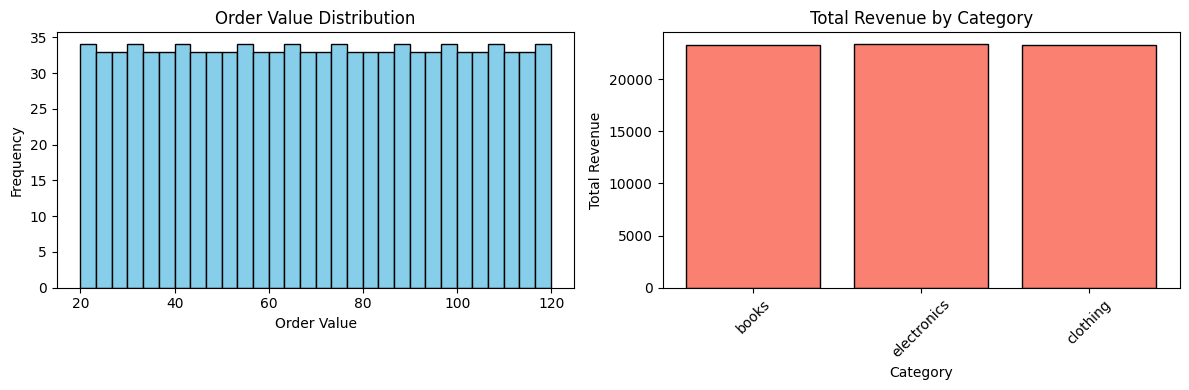

In [4]:
df_pandas = processed_df.to_pandas()

plt.figure(figsize=(12, 4))

#subplot 1: Order Value Distribution
plt.subplot(1, 2, 1)
plt.hist(df_pandas['order_value'], bins=30, color='skyblue', edgecolor='black')
plt.title('Order Value Distribution')
plt.xlabel('Order Value')
plt.ylabel('Frequency')


#subplot 2: Revenue by Category
plt.subplot(1, 2, 2)
summary_pandas = summary.to_pandas()
plt.bar(summary_pandas['category'], summary_pandas['total_revenue'], color='salmon', edgecolor='black')
plt.title('Total Revenue by Category')
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [5]:
conn = duckdb.connect()

conn.execute("CREATE TABLE IF NOT EXISTS orders AS SELECT * FROM processed_df")

result = conn.execute("SELECT category, AVG(order_value) AS avg_order_value FROM orders GROUP BY category").fetchall()   
print("\n Data from DuckDB:")
for row in result:
    print(f"{row[0]}:${row[1]:.2f}")

conn.close()


 Data from DuckDB:
clothing:$70.00
electronics:$69.95
books:$69.90
